In [2]:
#  ! pip install -U accelerate
# ! pip install -U transformers

In [3]:
from IPython.display import Audio
import os
import random
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import  Wav2Vec2FeatureExtractor,HubertModel
from torchaudio import load, transforms
from torch.utils.data import DataLoader
from torchaudio.transforms import Resample
import torch
# import accelerate
from torch.utils.data import Dataset
import transformers
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix

In [4]:

from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'File uploaded: {filename}')


!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mansourehk/shemo-persian-speech-emotion-detection-database
!unzip -q shemo-persian-speech-emotion-detection-database.zip


Saving kaggle.json to kaggle.json
File uploaded: kaggle.json
 99% 819M/829M [00:06<00:00, 285MB/s]
100% 829M/829M [00:06<00:00, 131MB/s]


In [5]:


male_dir = 'male'
female_dir = 'female'
transcript_dir = 'transcript/final text'

# Get a list of .wav files in each directory
male_files = [f for f in os.listdir(male_dir) if f.endswith('.wav')]
female_files = [f for f in os.listdir(female_dir) if f.endswith('.wav')]

# Select two random files from each directory
selected_male_files = random.sample(male_files, 2)
selected_female_files = random.sample(female_files, 2)

def play_audio(file_path, dir):
    audio_path = os.path.join(dir, file_path)
    # Resample the audio
    y, sr = librosa.load(audio_path)
    print(sr)
    duration = librosa.get_duration(y=y, sr=sr)

    print(f"File: {file_path}, Sampling Rate: {sr} Hz, Gender: {dir} , duration in seconds : {duration:.1f}")

    # Load and print the corresponding transcript
    transcript_path = os.path.join(transcript_dir, f'{os.path.splitext(file_path)[0]}.ort')
    with open(transcript_path, 'r', encoding='utf-8') as transcript_file:
        transcript = transcript_file.read()
        print(f"Transcript: {transcript}")

    return Audio(y, rate=sr)

# Play two random files
for file in selected_male_files:
    display(play_audio(file, male_dir))

# Play two random files
for file in selected_female_files:
    display(play_audio(file, female_dir))


22050
File: M07N07.wav, Sampling Rate: 22050 Hz, Gender: male , duration in seconds : 2.3
Transcript: تو اون ساعت یکی دو نفر بیشتر اونجا نیستند



22050
File: M03W02.wav, Sampling Rate: 22050 Hz, Gender: male , duration in seconds : 1.5
Transcript: ببرمش بزارمش تو کوچه؟



22050
File: F21S01.wav, Sampling Rate: 22050 Hz, Gender: female , duration in seconds : 1.4
Transcript: تو بی‌عاطفه‎ای.



22050
File: F05N22.wav, Sampling Rate: 22050 Hz, Gender: female , duration in seconds : 7.9
Transcript: دکتر جهانگیری بروز چنین اختلال‎هایی رو ناشی از عوارض داروهایی می‌دونه که امیر ناگزیره مصرف کنه.



In [6]:
emotion_codes = {"S" : "sadness" , "A" : "anger" , "H" : "happiness" , "W" : "surprise" , "F" : "fear" , "N" : "neutral"}
labels_int = {"S" : 0 , "A" : 1 , "H" : 2 , "W" : 3 , "F" : 4 , "N" : 5}
all_files  = male_files + female_files
print(all_files)
print(f"size of dataset : {len(all_files)}")
unique_lengths = set(len(file) for file in all_files)

print("Unique lengths of strings:")
for length in unique_lengths:
    print(length)

['M12N01.wav', 'M48N02.wav', 'M26A24.wav', 'M26A04.wav', 'M43A16.wav', 'M10A02.wav', 'M23A02.wav', 'M29A11.wav', 'M34A08.wav', 'M27N60.wav', 'M38A02.wav', 'M20N06.wav', 'M41W03.wav', 'M47N23.wav', 'M29A02.wav', 'M56N03.wav', 'M28S07.wav', 'M22A02.wav', 'M04N21.wav', 'M07F01.wav', 'M08N09.wav', 'M55N03.wav', 'M04N47.wav', 'M21S01.wav', 'M11H06.wav', 'M16H06.wav', 'M30A04.wav', 'M15A08.wav', 'M28S09.wav', 'M28H03.wav', 'M34H05.wav', 'M41A05.wav', 'M26A39.wav', 'M31N12.wav', 'M40N46.wav', 'M04N68.wav', 'M02A05.wav', 'M02N16.wav', 'M03A05.wav', 'M47A02.wav', 'M52N03.wav', 'M47A17.wav', 'M15A07.wav', 'M26A03.wav', 'M27N40.wav', 'M25A58.wav', 'M08H02.wav', 'M18N14.wav', 'M32N02.wav', 'M28S24.wav', 'M03S14.wav', 'M03S01.wav', 'M25A31.wav', 'M28S21.wav', 'M12N20.wav', 'M28A22.wav', 'M22N17.wav', 'M12A39.wav', 'M22N29.wav', 'M25W02.wav', 'M03H01.wav', 'M16A23.wav', 'M53N26.wav', 'M44N01.wav', 'M51N07.wav', 'M12A55.wav', 'M06A01.wav', 'M04N63.wav', 'M40N35.wav', 'M03S02.wav', 'M03F01.wav', 'M52S

# so all of file names have the same structure first charachter = M , F (for gender)
2,3 :   speaker code
4 : emotion code
5,6 : utternace of the speaker in this emotion






In [7]:
#statistical analysis
emotion_counts = {}
gender_counts = {"F" : 0 , "M" : 0}
durations = []
for file in all_files :
  emotion_code = file[3]
  gender_code = file[0]
  if emotion_code in emotion_counts :
    emotion_counts[emotion_code] +=1
  else:
    emotion_counts[emotion_code] = 1

  gender_counts[gender_code] +=1
  if gender_code == "F" :
      audio_path = os.path.join('female', file)
      y, sr = librosa.load(audio_path, sr=16000)
      duration = librosa.get_duration(y=y, sr=sr)
      durations.append(duration)
  else :
      audio_path = os.path.join('male', file)
      y, sr = librosa.load(audio_path, sr=16000)
      duration = librosa.get_duration(y=y, sr=sr)
      durations.append(duration)



for emotion_code , count in emotion_counts.items() :
  print(f"{emotion_codes[emotion_code]} : {count}")

print(gender_counts)





neutral : 1028
anger : 1059
surprise : 225
sadness : 449
fear : 38
happiness : 201
{'F': 1263, 'M': 1737}


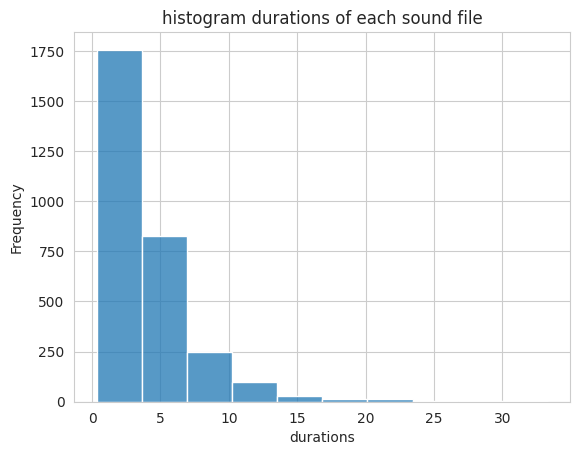

In [8]:
#plot the durations histogram
sns.set_style("whitegrid")
sns.histplot(durations, bins=10, kde=False)
plt.xlabel('durations')
plt.ylabel('Frequency')
plt.title("histogram durations of each sound file")
plt.show()

In [19]:
class HubertDataset(Dataset):
    def __init__(self, data_list, target_sample_rate=16000, max_length_seconds=10):
        self.data_list = data_list
        self.target_sample_rate = target_sample_rate
        self.max_length_seconds = max_length_seconds
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        audio_path, label = self.data_list[idx]
        waveform, sample_rate = load(audio_path)
        resample_transform = Resample(orig_freq=22050, new_freq=self.target_sample_rate)
        resampled_waveform = resample_transform(waveform)
        waveform = resampled_waveform[:int(self.target_sample_rate * self.max_length_seconds)]  # Truncate audio
        inputs = self.feature_extractor(
            waveform.squeeze(),
            sampling_rate=self.target_sample_rate,
            return_tensors="pt",
            padding="max_length",
            padding_value=0.0,
            do_normalize=True,
            feature_size=1,
            max_length=int(self.target_sample_rate * self.max_length_seconds),
            truncation=True)
        labels = torch.tensor([label])

        return inputs, labels


In [20]:

train_data = []

for gender in ["male", "female"]:
    count = 0
    for filepath in os.listdir(gender):
        if count >= 500:
            break  # Stop after the first 50 files
        label = labels_int[filepath[3]]
        audio_path = os.path.join(gender, filepath)
        train_data.append((audio_path, label))
        count += 1

In [21]:
    # for inputs,labels in train_loader:
    #     print(labels.shape)
    #     break

In [22]:
    # for inputs,labels in train_loader:
    #     print(inputs)
    #     break

In [23]:
total_size = len(train_data)
train_size = int(0.8 * total_size)
valid_size = int(0.1 * total_size)
test_size = total_size - train_size - valid_size
hubert_dataset = HubertDataset(train_data)
train_dataset, valid_dataset, test_dataset = random_split(hubert_dataset, [train_size, valid_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [24]:
# Fine-tune the model


# train_loader = DataLoader(hubert_dataset, batch_size=2, shuffle=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [25]:
# device = "cpu"

In [26]:
class CustomHubertModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomHubertModel, self).__init__()
        self.hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
        for param in self.hubert_model.feature_extractor.parameters():
            param.requires_grad = False
        self.classification_head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids):
        output = self.hubert_model(input_ids)
        mean_hidden_state = output.last_hidden_state.mean(dim=1)  # Calculate mean along the sequence length dimension
        logits = self.classification_head(mean_hidden_state)
        return logits
        # logits = self.classification_head(output.last_hidden_state[:, 0, :])
        # return logits

# Instantiate the custom model with 6 classes
model = CustomHubertModel(num_classes=6)
model.to(device)

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

CustomHubertModel(
  (hubert_model): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Hub

In [27]:
epochs = 5
model.to(device)
model.train()
optimizer  =  torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

In [28]:
for epoch in range(epochs):
    total_loss = 0
    tqdm_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

    for input, labels in tqdm_loader:
        optimizer.zero_grad()
        input_ids = input['input_values'].to(device)
        labels = (labels).squeeze().to(device)
        logits = model(input_ids.squeeze())
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        tqdm_loader.set_postfix({'Loss': loss.item()}, refresh=True)

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss}')

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input, labels in valid_loader:
            input_ids = input['input_values'].to(device)
            labels = labels.squeeze().to(device)
            logits = model(input_ids.squeeze())
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    model.train()

Epoch 1/5, Average Loss: 1.5046706175804139
Validation Accuracy: 32.00%


Epoch 2/5, Average Loss: 1.4811904060840606
Validation Accuracy: 32.00%


Epoch 3/5, Average Loss: 1.4784848415851592
Validation Accuracy: 38.00%


Epoch 4/5, Average Loss: 1.4625205028057098
Validation Accuracy: 38.00%


Epoch 5/5, Average Loss: 1.4654374051094055
Validation Accuracy: 38.00%


In [29]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for input, labels in test_loader:
        input_ids = input['input_values'].to(device)
        labels = labels.squeeze().to(device)
        logits = model(input_ids.squeeze())
        _, predicted = torch.max(logits, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 29.00%


['anger', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
tensor([[ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141]],
       device='cuda:0')
tensor([[ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.5798,  1.3368, -0.3013, -0.5264, -2.2873,  1.0141],
        [ 0.57

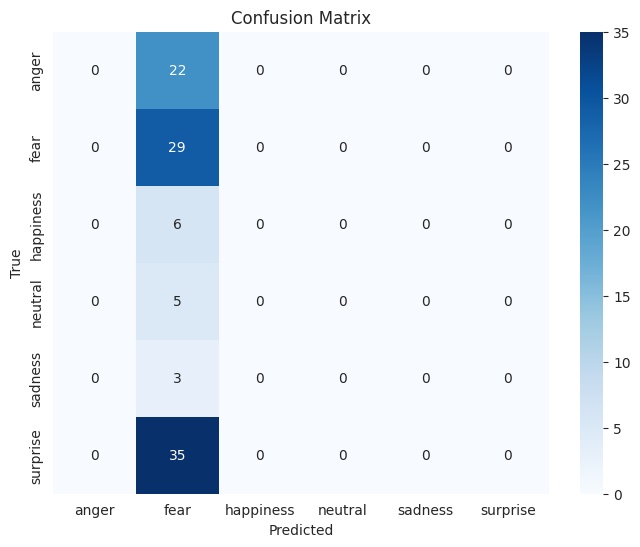

In [33]:

model.eval()
all_labels = []
all_predictions = []
class_labels = [emotion_codes[code] for code in sorted(emotion_codes.keys())]
print(class_labels)
with torch.no_grad():
    for input, labels in test_loader:
        input_ids = input['input_values'].to(device)
        labels = labels.squeeze().to(device)
        logits = model(input_ids.squeeze())
        print(logits)
        _, predicted = torch.max(logits, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
